Dataset shape: (101766, 50)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures     

<Figure size 1500x1000 with 0 Axes>

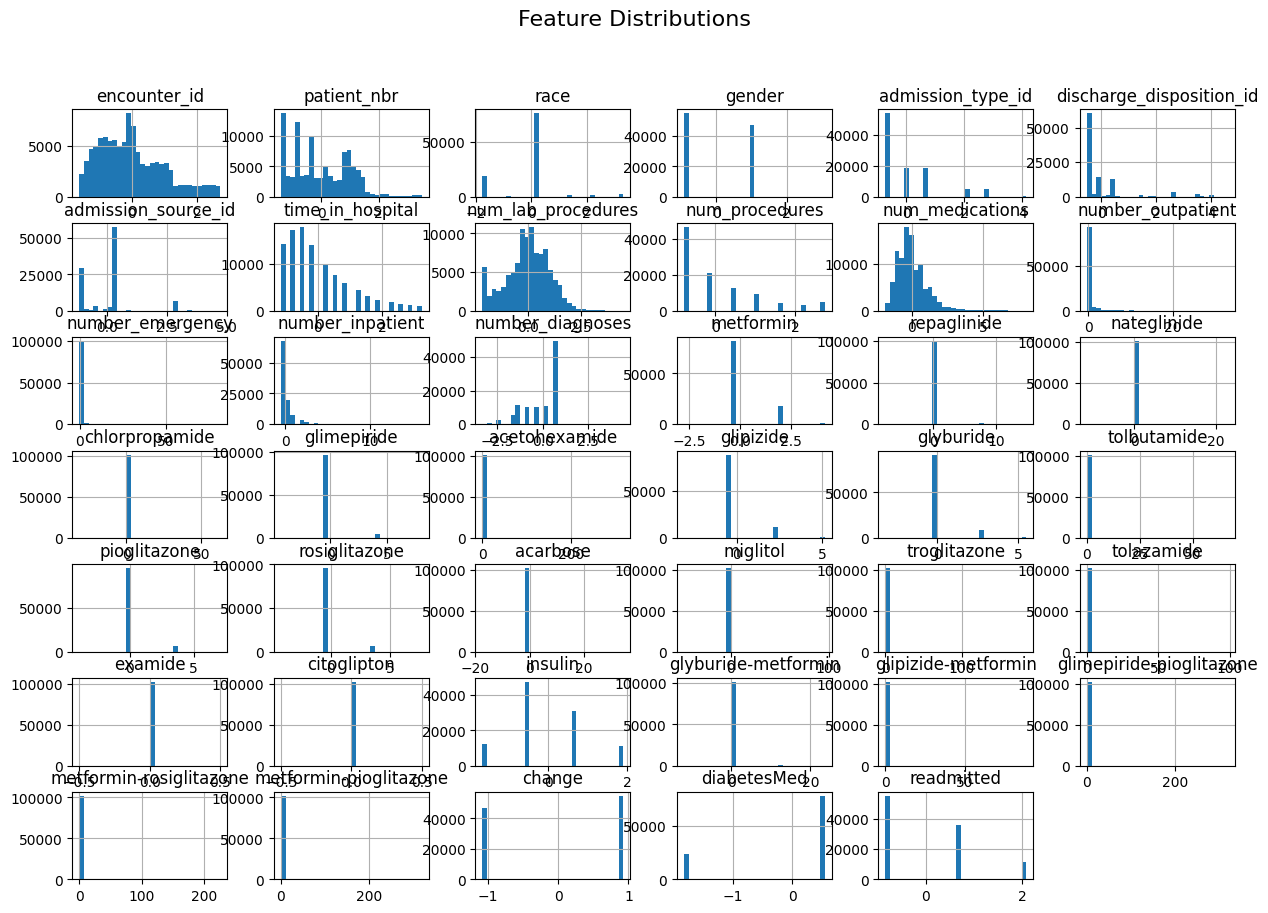

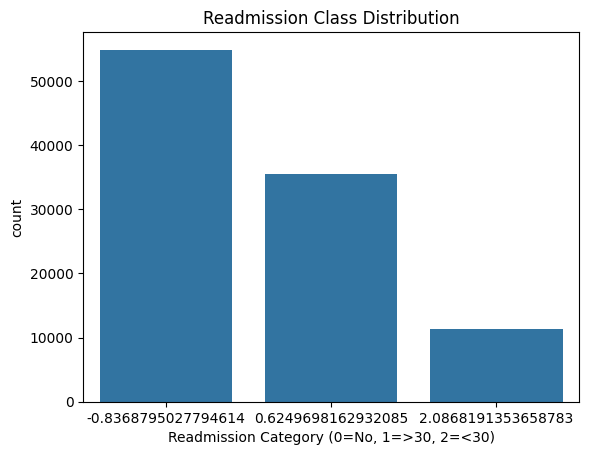

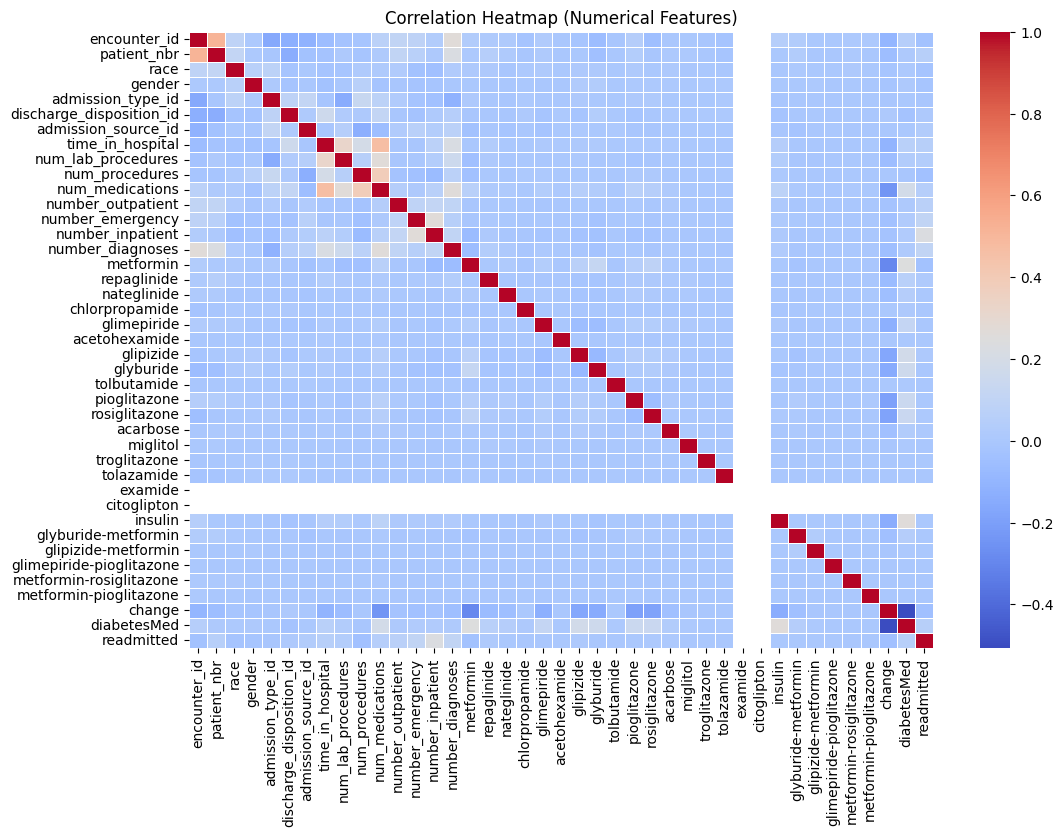

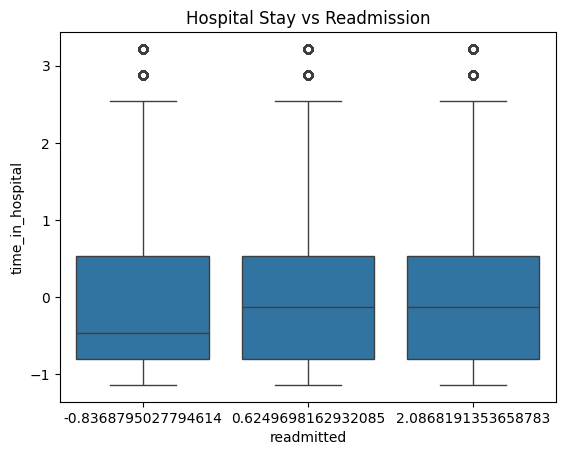

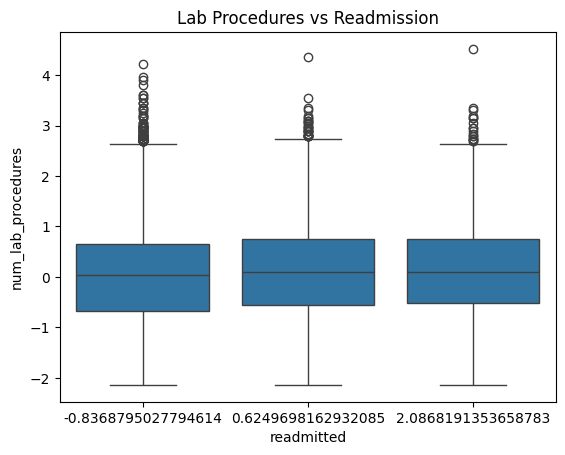

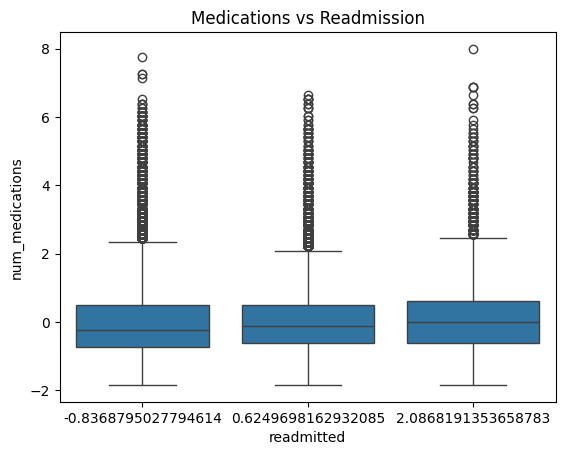

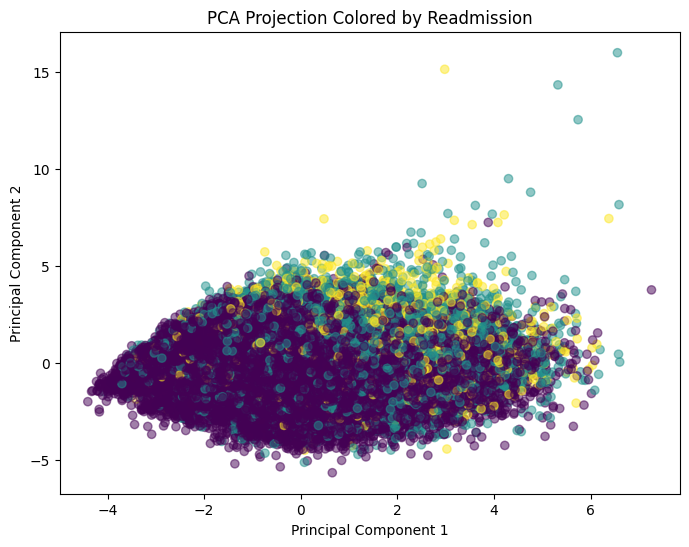

In [1]:
# DiagnoLearn: Data Preprocessing & Exploratory Data Analysis (EDA)
# CMPT 459 Fall 2025 Project - Group Notebook

# --- 1. Setup & Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# --- 2. Load Datasets ---
# Load main dataset and mapping file from the 'data' folder
df = pd.read_csv("data/diabetic_data.csv")
ids = pd.read_csv("data/IDS_mapping.csv")

print("Dataset shape:", df.shape)
df.head()

# --- 3. Initial Inspection ---
print("\nData info:")
df.info()
print("\nMissing value summary:")
print(df.isnull().sum().sort_values(ascending=False).head(15))
print("\nQuestion mark counts (often indicate missing):")
print((df == '?').sum().sort_values(ascending=False).head(15))

# --- 4. Handle Missing Values ---
# Replace '?' placeholders with NaN
df = df.replace('?', np.nan)

# Drop columns with >40% missing values
threshold = 0.4 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# Fill remaining missing values for categorical features with 'Unknown'
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna('Unknown')

print("\nRemaining missing values:")
print(df.isnull().sum().sum())

# --- 5. Encode Categorical Variables ---
# Map target variable 'readmitted'
df['readmitted'] = df['readmitted'].map({'NO':0, '>30':1, '<30':2})

# Encode small categorical variables
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()

for col in cat_cols:
    if df[col].nunique() < 10:
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

print("\nCategorical encoding complete. Current shape:", df.shape)

# --- 6. Normalize Numeric Features ---
num_cols = df.select_dtypes(include=['int64','float64']).columns
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

print("\nNumeric normalization complete.")

# --- 7. Exploratory Data Analysis (EDA) ---

## 7.1 Distributions
plt.figure(figsize=(15,10))
df[num_cols].hist(figsize=(15,10), bins=30)
plt.suptitle('Feature Distributions', fontsize=16)
plt.show()

## 7.2 Target Distribution
sns.countplot(x='readmitted', data=df)
plt.title('Readmission Class Distribution')
plt.xlabel('Readmission Category (0=No, 1=>30, 2=<30)')
plt.show()

## 7.3 Correlation Heatmap
corr = df[num_cols].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

## 7.4 Relationships Between Key Features
sns.boxplot(x='readmitted', y='time_in_hospital', data=df)
plt.title('Hospital Stay vs Readmission')
plt.show()

sns.boxplot(x='readmitted', y='num_lab_procedures', data=df)
plt.title('Lab Procedures vs Readmission')
plt.show()

sns.boxplot(x='readmitted', y='num_medications', data=df)
plt.title('Medications vs Readmission')
plt.show()

# --- 8. Dimensionality Reduction (Optional Visualization) ---
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[num_cols])
plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df['readmitted'], cmap='viridis', alpha=0.5)
plt.title('PCA Projection Colored by Readmission')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Brief Notes

## EDA Summary
# - The dataset has 101,766 patient encounters and 47 original features (demographics, labs, diagnoses, and medications).
# - Numeric features like `num_lab_procedures`, `time_in_hospital`, and `num_medications` are right-skewed — most patients have short stays and few procedures.
# - The target variable `readmitted` is imbalanced: about 55% “No”, 33% “>30 days”, and 12% “<30 days”.
# - Categorical features such as `race`, `gender`, and `admission_type_id` vary widely in frequency.

## Key Insights
# - Patients with longer hospital stays and more procedures or medications are more likely to be readmitted.
# - Older age groups and certain admission types show higher readmission risk.
# - The correlation heatmap shows moderate positive relationships between medical procedure counts.
# - PCA suggests much of the variance can be explained by a few components, indicating feature redundancy.

## Challenges
# - Many fields (e.g., `weight`, `payer_code`, `medical_specialty`, `max_glu_serum`, `A1Cresult`) have many missing or coded values (`'?'`).
# - Class imbalance may cause models to overpredict “No readmission.”
# - One-hot encoding greatly increases dimensionality (to ~2,392 columns).

## Future Steps
# - Use SMOTE or resampling to handle class imbalance.
# - Apply feature selection or PCA to reduce redundancy.
# - Train and evaluate models such as Logistic Regression, Random Forest, or Gradient Boosting for readmission prediction.